Here come one of the most important trading pairs of crypto. In very high density data too. Let's see if we can spot some interesting effects from the data.

In [1]:
# Comment if not running in Colab
!pip install lakeapi -q

In [2]:
#  Imports
import datetime as dt
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline

import lakeapi

lakeapi.use_sample_data(anonymous_access=True)

We'll do analysis on BTC-USDT since it's the highest volume and density data we've got available.

In [3]:
for table in ('level_1', 'trades', 'book', 'candles'):
 	available_data = pd.DataFrame(lakeapi.list_data(table = table))
 	print(table)
 	display(available_data[['exchange', 'symbol', 'dt']].groupby(['exchange', 'symbol']).aggregate({'dt': ['first', 'last']}))

ERROR:botocache.botocache:Error encountered : 'NoneType' object has no attribute 'access_key'. Retrying the same call without cached context.


level_1


dt            
                         first        last
exchange symbol                           
ASCENDEX CNS-USDT   2022-09-01  2022-10-15
         FINE-USDT  2022-09-01  2022-10-15
         FTRB-USDT  2022-09-01  2022-11-20
BINANCE  BTC-USDT   2022-10-01  2022-10-15
         RLC-USDT   2022-09-01  2022-10-15
GATEIO   AVAX-USDT  2022-11-01  2022-11-15
         FTRB-USDT  2022-11-01  2022-11-20

ERROR:botocache.botocache:Error encountered : 'NoneType' object has no attribute 'access_key'. Retrying the same call without cached context.


trades


dt            
                         first        last
exchange symbol                           
ASCENDEX CNS-USDT   2022-09-01  2022-10-15
         FINE-USDT  2022-09-01  2022-10-15
         FTRB-USDT  2022-09-01  2022-11-20
BINANCE  BTC-USDT   2022-10-01  2022-10-03
         RLC-USDT   2022-09-01  2022-10-15
GATEIO   AVAX-USDT  2022-11-01  2022-11-15
         FTRB-USDT  2022-11-01  2022-11-20

ERROR:botocache.botocache:Error encountered : 'NoneType' object has no attribute 'access_key'. Retrying the same call without cached context.


book


dt            
                         first        last
exchange symbol                           
ASCENDEX FTRB-USDT  2022-11-01  2022-11-20
BINANCE  BTC-USDT   2022-10-01  2022-10-03

ERROR:botocache.botocache:Error encountered : 'NoneType' object has no attribute 'access_key'. Retrying the same call without cached context.


candles


dt            
                        first        last
exchange symbol                          
BINANCE  BTC-USDT  2022-10-01  2022-10-03

In [4]:
# Parameters
symbol = 'BTC-USDT'
exchange = 'BINANCE'

start = dt.datetime(2022, 10, 1)
end = dt.datetime(2022, 10, 15)

In [5]:
def load_data(table: str):
    print('Loading', table)
    return lakeapi.load_data(
        table = table,
        start = start,
        end = end,
        symbols = [symbol],
        exchanges = [exchange],
        drop_partition_cols = True,
    ).sort_values('received_time')

# Load trades
trades = load_data('trades')
# Load book
book = load_data('book')
# Load candles
candles = load_data('candles')

Loading trades


  0%|          | 0/3 [00:00<?, ?it/s]

Loading book


  0%|          | 0/3 [00:00<?, ?it/s]

Loading candles


  0%|          | 0/3 [00:00<?, ?it/s]

## Is this a profitable pair?

The first big question is *"Is this a pair that a market maker can make money?"*. Since the full book is huge can will easily crash Colab we'll get the l1 sub-set first to answer this question.

In [6]:
l1 = book[['received_time', 'bid_0_price', 'bid_0_size', 'ask_0_price', 'ask_0_size']]

In [7]:
df = pd.merge_asof(
	left = trades.rename(columns = {'origin_time': 'trade_origin_time', 'received_time': 'trade_received_time'}),
	right = l1.rename(columns = {'received_time': 'depth_received_time'}),
	left_on = 'trade_received_time',
	right_on = 'depth_received_time',
  tolerance = pd.Timedelta(minutes = 120),
)
df = df.dropna()
df['mid'] = (df.bid_0_price + df.ask_0_price) / 2
df

<ipython-input-7-e2ecd7e4db32>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mid'] = (df.bid_0_price + df.ask_0_price) / 2


,side,quantity,price,trade_id,trade_origin_time,trade_received_time,depth_received_time,bid_0_price,bid_0_size,ask_0_price,ask_0_size,mid
40,buy,0.00131,19423.92,1640546282,2022-10-01 00:00:00.032999936,2022-10-01 00:00:00.286983936,2022-10-01 00:00:00.279075840,19422.61,0.01822,19423.92,0.00150,19423.265
41,sell,0.00079,19422.61,1640546283,2022-10-01 00:00:00.036999936,2022-10-01 00:00:00.287016704,2022-10-01 00:00:00.279075840,19422.61,0.01822,19423.92,0.00150,19423.265
42,sell,0.00087,19422.61,1640546284,2022-10-01 00:00:00.036999936,2022-10-01 00:00:00.287030784,2022-10-01 00:00:00.279075840,19422.61,0.01822,19423.92,0.00150,19423.265
43,sell,0.01656,19422.61,1640546285,2022-10-01 00:00:00.043000064,2022-10-01 00:00:00.287042816,2022-10-01 00:00:00.279075840,19422.61,0.01822,19423.92,0.00150,19423.265
44,sell,1.54602,19422.60,1640546286,2022-10-01 00:00:00.043000064,2022-10-01 00:00:00.287054848,2022-10-01 00:00:00.279075840,19422.61,0.01822,19423.92,0.00150,19423.265
...,...,...,...,...,...,...,...,...,...,...,...,...
8979886,buy,0.01568,19628.56,1649526367,2022-10-03 23:59:59.989000192,2022-10-03 23:59:59.993817600,2022-10-03 23:59:59.923665152,19627.39,0.23124,19628.19,0.00056,19627.790
8979887,buy,0.00754,19628.82,1649526368,2022-10-03 23:59:59.989000192,2022-10-03 23:59:59.993905152,2022-10-03 23:59:59.923665152,19627.39,0.23124,19628.19,0.00056,19627.790
8979888,buy,0.02031,19628.90,1649526369,2022-10-03 23:59:59.989000192,2022-10-03 23:59:59.994291968,2022-10-03 23:59:59.923665152,19627.39,0.23124,19628.19,0.00056,19627.790
8979889,buy,0.00075,19628.90,1649526370,2022-10-03 23:59:59.990000128,2022-10-03 23:59:59.994332160,2022-10-03 23:59:59.923665152,19627.39,0.23124,19628.19,0.00056,19627.790


From looking at a few rows I can see that the traded price don't happen 

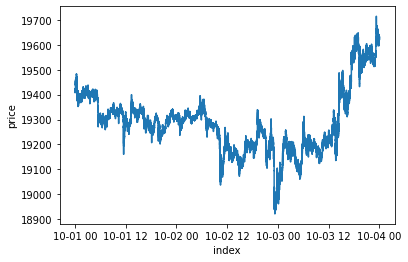

In [8]:
fig, ax = plt.subplots()
ax.plot(df['trade_received_time'], df['mid']);
ax.set_xlabel('index');
ax.set_ylabel('price');

Looks like BTC-USDT, no gaps.

In [9]:
df1 = df[['side','price', 'mid']]
df1['forward_mid'] = df1['mid'].shift(-1)
df1 = df1.dropna()
df1['pnl'] = np.where(df1['side'] == 'buy', df1['forward_mid'] - df1['price'], df1['price'] - df1['forward_mid'])

<ipython-input-9-ba85c96909d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['forward_mid'] = df1['mid'].shift(-1)


In [10]:
df1['pnl'].describe().round(2)

count    8979850.00
mean          -0.74
std            1.37
min          -32.24
25%           -0.90
50%           -0.45
75%           -0.17
max           28.44
Name: pnl, dtype: float64

As the most liquid pair in the world. Not surprisingly the bid-ask spread is negative mean. I assume there's the combination of aggressive hedging in perp and exchange rebates help soften the pain of million cuts. To think that this period is rather gentle...

In [11]:
del df1

## Backtest

We've established that the bid-ask spread of BTC-USDT isn't profitable to market make on. I wonder what are the levels that we'll need to go until the pair is profitable. Using the function from [Hummingbot Backtest notebook](https://mybinder.org/v2/gh/crypto-lake/analysis-sharing/main?filepath=hummingbot_backtest.ipynb) I can conduct a stepped backtest of basis points.

This was originally meant to come last after we've explored factors but Lefty suggested clearing used DFs to free up memory since we have a lot of data so I moved this here.

In [12]:
results = []
trades_lookahead = 1000
tick_size_decimals = 5
fees_bps = 10
spread_to_plot = 200
df_to_plot = None
for spread_bps in range(1, 20, 1):
	df['spread_bps'] = spread_bps
	df['future_price'] = df.mid.shift(-trades_lookahead)
	df['quote_bid'] = round(df.bid_0_price * (1 - df.spread_bps * 0.0001), tick_size_decimals)
	df['quote_ask'] = round(df.ask_0_price * (1 + df.spread_bps * 0.0001), tick_size_decimals)
	df['fill_sign'] = 0
	df.loc[df.quote_bid > df.price, 'fill_sign'] = 1
	df.loc[df.quote_bid > df.price, 'fill_price'] = df.quote_bid
	df.loc[df.quote_ask < df.price, 'fill_sign'] = -1
	df.loc[df.quote_ask < df.price, 'fill_price'] = df.quote_ask
	df['gross_profitability_short_bps'] = 10_000 * (df.future_price - df.fill_price) / df.fill_price * df.fill_sign 
	df['net_profitability_short_bps'] = (df['gross_profitability_short_bps'] - 2*fees_bps) * df.fill_sign.abs()
	fill_count = df.fill_sign.abs().sum()
	results.append((spread_bps, fill_count, df.gross_profitability_short_bps.sum() / fill_count))
	if spread_to_plot == spread_bps:
		df_to_plot = df.copy()

result_df = pd.DataFrame(results, columns = ['spread_bps', 'fill_count', 'gross_profitability_short_bps'])
result_df['net_profitability_short_bps'] = result_df.gross_profitability_short_bps - 2*fees_bps
result_df['total_gross_profit_bps'] = result_df.gross_profitability_short_bps * result_df.fill_count
result_df['total_net_profit_bps'] = result_df.net_profitability_short_bps * result_df.fill_count
result_df.round(2)

<ipython-input-12-5909a4e6f4af>:20: RuntimeWarning: invalid value encountered in double_scalars
  results.append((spread_bps, fill_count, df.gross_profitability_short_bps.sum() / fill_count))


,spread_bps,fill_count,gross_profitability_short_bps,net_profitability_short_bps,total_gross_profit_bps,total_net_profit_bps
0,1,729783,-0.84,-20.84,-613626.40,-15209286.40
1,2,249915,-0.93,-20.93,-232732.83,-5231032.83
2,3,104016,-0.86,-20.86,-89859.69,-2170179.69
3,4,45764,-0.73,-20.73,-33366.36,-948646.36
4,5,21008,-0.68,-20.68,-14285.94,-434445.94
5,6,10459,-0.52,-20.52,-5445.31,-214625.31
6,7,5443,0.02,-19.98,124.44,-108735.56
7,8,2860,0.92,-19.08,2624.51,-54575.49
8,9,1517,1.44,-18.56,2182.30,-28157.70
9,10,880,1.92,-18.08,1686.38,-15913.62


Result: For most people == NOPE! Find other sources of edges unless Binance give you zero or negative fees.

In [13]:
del df, result_df

## Spread Factors

From the previous notebook [Crypto Microstructure - L1 & Trades Exploratory Analysis](https://colab.research.google.com/drive/1FgtFjTgJ_EHgppunODOm7kRwtYToGnHe?usp=sharing) I took a look at the factors affecting the spread. Though we're working with fewer days of data here it's a lot more dense. Let's see if we can spot some interesting effects.

### Spread

I'll be looking at seasonality after so I resample the data to 5min. Since we now have spread data at reasonable frequency let's take a look.

In [14]:
# Load  more complete l1 from API
l1 = load_data('level_1')
df3 = l1[['bid_0_price', 'ask_0_price']]
df3 = df3.rename(columns = {'bid_0_price': 'bid', 'ask_0_price': 'ask'})
df3['datetime'] = pd.to_datetime(l1['received_time'])
df3 = df3.set_index('datetime')
df4 = df3.resample('5min').mean()
df4 = df4.dropna()
df4['minute'] = df4.index.minute
df4['hour'] = df4.index.hour
df4['spread'] = round((df4['ask'] - df4['bid']) / ((df4['ask'] + df4['bid']) / 2) * 10000, 2)
df4

Loading level_1


  0%|          | 0/14 [00:00<?, ?it/s]

,bid,ask,minute,hour,spread
datetime,,,,,
2022-10-01 00:00:00,19416.520250,19417.200653,0,0,0.35
2022-10-01 00:05:00,19444.273736,19444.810623,5,0,0.28
2022-10-01 00:10:00,19450.463120,19451.008102,10,0,0.28
2022-10-01 00:15:00,19459.412164,19459.945851,15,0,0.27
2022-10-01 00:20:00,19470.296922,19470.911680,20,0,0.32
...,...,...,...,...,...
2022-10-14 23:35:00,19178.690976,19179.511587,35,23,0.43
2022-10-14 23:40:00,19180.861249,19181.720589,40,23,0.45
2022-10-14 23:45:00,19179.928714,19180.756064,45,23,0.43


In [15]:
df4['spread'].describe().round(2)

count    2881.00
mean        0.32
std         0.11
min         0.06
25%         0.24
50%         0.31
75%         0.40
max         1.77
Name: spread, dtype: float64

From the 5min data resample. The mean and median spread is just 0.3 bps. Sounds like it's hard to trade at a bad price for a highly liquid instrument.

### Seasonality

We'll look at parts of the hour and zoom back out. Remember we're just working with just a few days of data. That said, this looks flat in 5 min sequence.

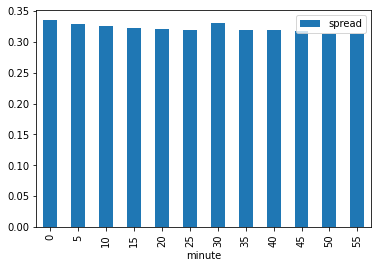

In [16]:
df4.groupby('minute')['spread'].mean().plot(kind='bar', legend=True)

Hmm, something here seems to be different. From the 12-hour peak in some other data the peak spread here is at 14-hour. Again, too few days to tell but assuming this is persistent suggests a lead-lag relationship. For which happening on a pair like BTC-USDT would be a huge anomaly indeed.

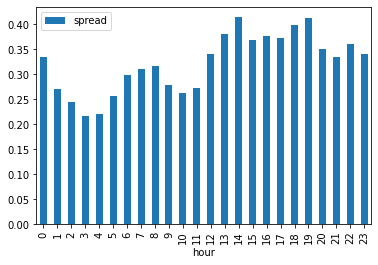

In [17]:
df4.groupby('hour')['spread'].mean().plot(kind='bar', legend=True)

In [18]:
del df3, df4

### Bid/Ask Volume Ratio

Let's start with the top of book then figure out how we're going to look deeper into the book. Bid/ask ratio is meant to look at the amount of buy and sell orders in the book. This is also called orderbook imbalance. It's been suggested by Lefty to normalized the range from -1 to 1. Number below 1 means there's more sell orders in the book, the assumption is that it is bearish. Number above 0 means there's more buy orders in the book, the assumption is that it is bullish.

In [19]:
df5 = l1[['bid_0_price', 'ask_0_price', 'bid_0_size', 'ask_0_size']]
df5['datetime'] = pd.to_datetime(l1['received_time'])
df5['mid_price'] = (df5['bid_0_price'] + df5['ask_0_price']) / 2
df5 = df5.set_index('datetime')
df5 = df5.resample('5min').first()
df5 = df5.dropna()
df5['spread'] = round((df5['ask_0_price'] - df5['bid_0_price']) / ((df5['ask_0_price'] + df5['bid_0_price']) / 2) * 10000)
df5['log_returns'] = np.log(df5['mid_price'] / df5['mid_price'].shift(1))
df5 = df5.dropna()
df5['imbalance_ratio'] = round((df5['bid_0_size'] - df5['ask_0_size']) / (df5['bid_0_size'] + df5['ask_0_size']), 1)
df5['imbalance_ratio'].describe().round(2)

count    2880.00
mean        0.03
std         0.69
min        -1.00
25%        -0.70
50%         0.10
75%         0.70
max         1.00
Name: imbalance_ratio, dtype: float64

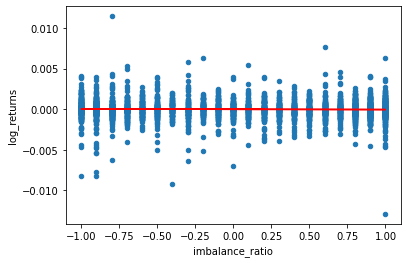

In [20]:
df5.plot.scatter(x = 'imbalance_ratio', y = 'log_returns')
slope, intercept = np.polyfit(df5['imbalance_ratio'], df5['log_returns'], 1)
plt.plot(df5['imbalance_ratio'], slope * df5['imbalance_ratio'] + intercept, color = 'red')

I had the cut off at 75th percentile of 6 bid/ask ratio. Well it's looking pretty flat to me. At ratio below 0 there seems to be a more instances of downside moves but eyes can be deceptive, the regression line is flat. The heavier directional anti-correlation returns was possible when ratio is at extremes. The effect is small but might be tested as a safety net for HFT plays.

In [21]:
del df5

## Book Data

I'll create a new dataframe that summarise the data that we'll be looking at from book. Still the ratio but aggregating the L2 book.


In [22]:
book

,origin_time,received_time,sequence_number,bid_0_price,bid_0_size,bid_1_price,bid_1_size,bid_2_price,bid_2_size,bid_3_price,...,ask_15_price,ask_15_size,ask_16_price,ask_16_size,ask_17_price,ask_17_size,ask_18_price,ask_18_size,ask_19_price,ask_19_size
0,2022-10-01 00:00:00.032000000,2022-10-01 00:00:00.279075840,25095473073,19422.61,0.01822,19422.60,1.95358,19422.41,0.00634,19422.38,...,19424.95,1.07075,19424.98,0.02365,19425.00,0.02343,19425.04,0.00056,19425.06,0.51477
1,2022-10-01 00:00:00.132000000,2022-10-01 00:00:00.287162112,25095473151,19422.32,0.00675,19422.25,0.02000,19422.15,0.00695,19422.08,...,19424.94,0.69584,19424.95,1.07075,19424.98,0.02365,19425.00,0.02343,19425.04,0.00056
2,2022-10-01 00:00:00.232999936,2022-10-01 00:00:00.294583040,25095473227,19422.37,0.25742,19422.33,0.00233,19422.15,0.00695,19422.01,...,19424.64,0.10000,19424.67,0.00090,19424.73,0.00257,19424.78,0.00554,19424.93,0.06490
3,2022-10-01 00:00:00.332999936,2022-10-01 00:00:00.962390272,25095473285,19422.38,0.08603,19422.37,0.25742,19422.15,0.00695,19422.01,...,19424.64,0.10000,19424.67,0.00090,19424.73,0.00257,19424.78,0.00554,19424.93,0.06490
4,2022-10-01 00:00:00.433000192,2022-10-01 00:00:00.969885440,25095473369,19422.02,0.02000,19422.01,0.82559,19421.98,0.00122,19421.92,...,19424.29,0.00645,19424.37,0.01524,19424.56,0.00479,19424.57,0.34500,19424.64,0.10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2590398,2022-10-03 23:59:59.519000064,2022-10-03 23:59:59.523761664,25210698129,19625.19,1.70863,19625.11,0.00056,19624.80,0.00114,19624.63,...,19627.94,0.01000,19628.31,0.08250,19628.33,0.00254,19628.44,0.00999,19628.64,0.01456
2590399,2022-10-03 23:59:59.619000064,2022-10-03 23:59:59.624189184,25210698185,19625.20,0.24378,19625.19,1.70744,19625.11,0.00056,19624.89,...,19627.94,0.01000,19628.31,0.08250,19628.33,0.00254,19628.44,0.00999,19628.64,0.01456
2590400,2022-10-03 23:59:59.719000064,2022-10-03 23:59:59.723825920,25210698232,19626.54,0.03437,19625.22,0.42000,19625.21,0.00887,19625.19,...,19627.94,0.01000,19628.31,0.08250,19628.33,0.00254,19628.44,0.00999,19628.64,0.01456
2590401,2022-10-03 23:59:59.819000064,2022-10-03 23:59:59.821303808,25210698456,19628.00,0.03437,19627.76,0.42000,19626.86,0.00898,19626.82,...,19630.25,0.00657,19630.33,0.00060,19630.41,0.12065,19630.61,0.01265,19630.67,0.01000


In [39]:
book_size = book.filter(like='size')
book_bid_size = book_size.filter(like='bid')
book_ask_size = book_size.filter(like='ask')
book_bid_sum = book_bid_size.sum(axis=1)
book_ask_sum = book_ask_size.sum(axis=1)

In [41]:
l2 = book[['bid_0_price', 'ask_0_price']]
l2['bid_size'] = book_bid_sum
l2['ask_size'] = book_ask_sum
l2['mid_price'] = (l2['bid_0_price'] + l2['ask_0_price']) / 2
l2['spread'] = round((l2['ask_0_price'] - l2['bid_0_price']) / ((l2['ask_0_price'] + l2['bid_0_price']) / 2) * 10000, 2)
l2['log_returns'] = np.log(l2['mid_price'] / l2['mid_price'].shift(50))
l2 = l2.dropna()
l2['imbalance_ratio'] = round((l2['bid_size'] - l2['ask_size']) / (l2['bid_size'] + l2['ask_size']), 1)

<ipython-input-41-ea2d6e7a086d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l2['bid_size'] = book_bid_sum
<ipython-input-41-ea2d6e7a086d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l2['ask_size'] = book_ask_sum
<ipython-input-41-ea2d6e7a086d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [25]:
del book_size, book_bid_size, book_ask_size, book_bid_sum, book_ask_sum

In [42]:
l2

,bid_0_price,ask_0_price,bid_size,ask_size,mid_price,spread,log_returns,imbalance_ratio
50,19422.03,19422.99,9.48414,5.95350,19422.510,0.49,-0.000039,0.2
51,19422.04,19422.90,9.46002,6.24975,19422.470,0.44,-0.000026,0.2
52,19422.05,19422.89,7.88734,5.75557,19422.470,0.43,-0.000023,0.2
53,19422.06,19422.89,6.81141,5.31585,19422.475,0.43,-0.000022,0.1
54,19422.06,19422.89,6.71373,5.31974,19422.475,0.43,-0.000011,0.1
...,...,...,...,...,...,...,...,...
2590398,19625.19,19626.57,5.70621,3.61410,19625.880,0.70,-0.000108,0.2
2590399,19625.20,19626.56,4.49719,3.73617,19625.880,0.69,-0.000108,0.1
2590400,19626.54,19626.55,4.57914,3.57755,19626.545,0.01,-0.000074,0.1
2590401,19628.00,19628.75,4.86506,1.59287,19628.375,0.38,0.000019,0.5


### Imbalance Ratio L2

Now that we have aggregated the L2 book, let's take another go round at the bid/ask volume ratio. 

In [43]:
l2['imbalance_ratio'].describe().round(2)

count    2590353.00
mean           0.02
std            0.27
min           -1.00
25%           -0.10
50%            0.00
75%            0.20
max            1.00
Name: imbalance_ratio, dtype: float64

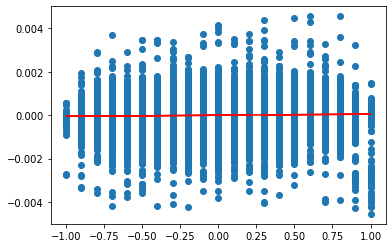

In [44]:
fig, ax = plt.subplots()
ax.scatter(x = l2['imbalance_ratio'], y = l2['log_returns'])
slope, intercept = np.polyfit(l2['imbalance_ratio'], l2['log_returns'], 1)
plt.plot(l2['imbalance_ratio'], slope * l2['imbalance_ratio'] + intercept, color = 'red')

The scatter here is flat too. Same picture with L1 data where ratio number above 0 seems to result in more volatile returns in the next period. With just a few days of data we have such big outliers already. And this is during a period where BTC-USDT isn't very volatile just look at the range in the plot above. The regression line sloping slightly upwards. Really, this is much stronger than I expected of a hugely traded instrument like this. So big and small bid/ask ratios show up often in crypto. When the book gets super tilted on one side don't be a hero and get steamrolled. Though the outliers suggest selling on the way up might be profitable with mean-reversion the regression line doesn't suggest that.

## Autocorrelation

Does a feature correlates with its future self? We can measure the features with this. The trader term for this is stickiness. 

Unfortunately we're not in GCP BigQuery at the moment so crunching millions upon millions of rows take too long. I'll downsample the data so we can actually finish the computation before next supernova.

In [45]:
acf = l2.iloc[::100, :] # take every 100th row

In [46]:
del l2

### Imbalance Ratio

The left-most value is supposed to be 1 because a thing is always correlated with itself. However I'm not quite sure in the rest of it. It's mostly positive but how much is that?

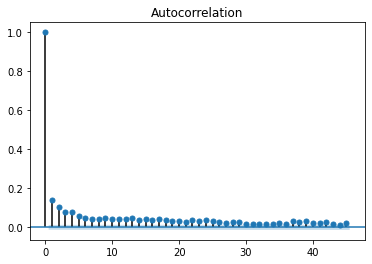

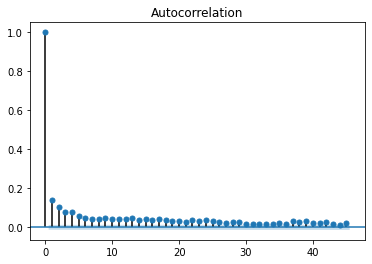

In [47]:
plot_acf(acf['imbalance_ratio'], alpha=0.05)

Let's zoom in by removing the 0th observation. Alpha = 0.05 means 95% confidence interval that this feature is autocorrelated. Oh wow, this is very strong. Orderbook skew tends to stay skewed. Even on this downsampled data too.

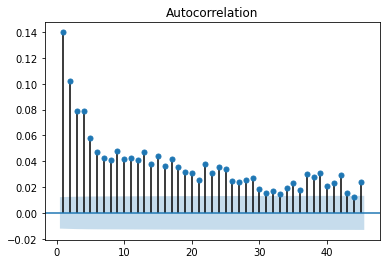

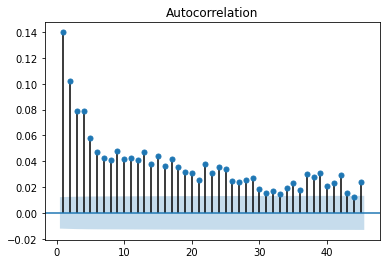

In [48]:
plot_acf(acf['imbalance_ratio'], alpha=0.05, zero=False)

### Spread

And I thought autocorrelation of imbalance ratio was impressive. Turns out that the spread is much more sticky. It looks like market makers are programmed to maintain the spread very well. I wonder how the data of maybe more dynamically sizing of spreads on volatile periods look like.

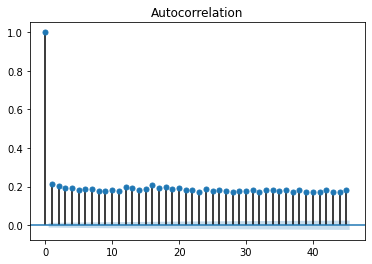

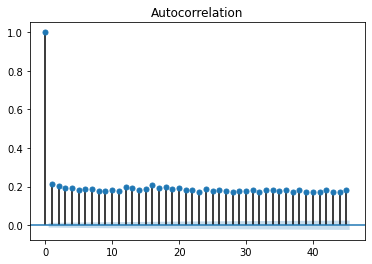

In [49]:
plot_acf(acf['spread'], alpha=0.05)

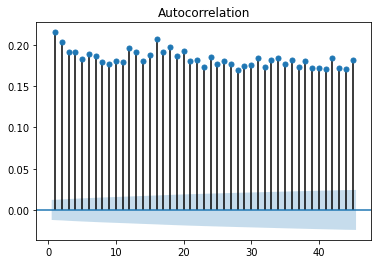

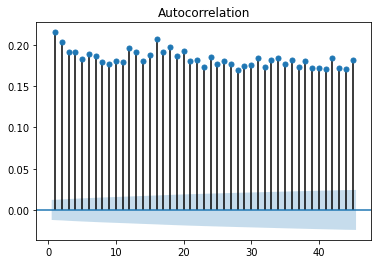

In [50]:
plot_acf(acf['spread'], alpha=0.05, zero=False)

### Returns

To round off the acf series, let's look at returns as this is not very reliable at large timescales. At first glance this looks weak like most financial data effects.

What a surprise, this is every 100th row resampling of a log return calculated every 50th row second and there's still pretty clearly anti-correlation effect after some seconds after. I've been warned of microstructure noise overstating mean reversion as we're seeing orders that hit the bid-ask top of book. There's the strange returns trending effect in 20-30 periods that I can't quite explain.

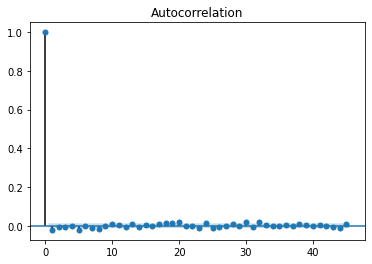

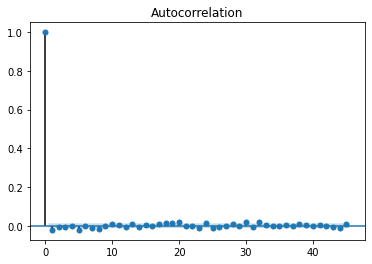

In [51]:
plot_acf(acf['log_returns'], alpha=0.05)

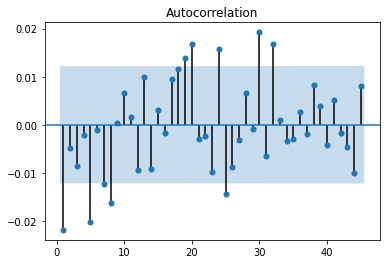

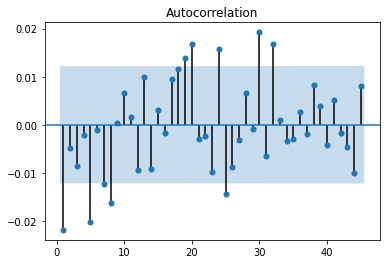

In [52]:
plot_acf(acf['log_returns'], alpha=0.05, zero=False)

## Wrapping Up

I got to plow through millions and million of rows thanks to [crypto-lake.com](https://crypto-lake.com/)'s sample/free market data and Lefty's accurate feedback. A lot of credit for code is due to my research companion [ChatGPT](https://chat.openai.com/chat). I got to explore many interesting features, stronger than I expected at the small but dense scale.

## What's Next?

I'm establishing some foundation in volatility land, there's more cool stuff to look it. Also the application side of markets too, where I try out lessons from research.